# 在原始空间中求解

In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

### 设置训练集和测试集数据

In [2]:
# 1 2 3
target = 2

if target==1:
    data_name = '0618'
elif target==2:
    data_name = '0854'
elif target==3:
    data_name = '1066'

# 设置训练集数据
# 获取指定的CSV文件
csv_files = glob.glob(f'./RGB_data/data_{data_name}_new.csv')

# 设置测试集数据
new_image_path = f'./input_data/{data_name}.png'

# TRAIN

In [3]:
# 初始化一个空的DataFrame来存储合并后的数据
data = pd.DataFrame()

# 遍历所有CSV文件并将它们合并
for file in csv_files:
    df = pd.read_csv(file)
    data = pd.concat([data, df], ignore_index=True)

# 现在all_data包含了所有CSV文件的数据
print(data.shape)

(43, 4)


In [4]:
# 读入特征和标签
features = data.drop('Label', axis=1) # 按列操作取名为’Label以外的列
labels = data['Label']
features.shape,labels.shape,type(features),type(labels)

((43, 3), (43,), pandas.core.frame.DataFrame, pandas.core.series.Series)

In [5]:
# 归一化
scaler = StandardScaler()

print(features.shape)
print(type(features))

features = scaler.fit_transform(features)
features = pd.DataFrame(features)

print(features.shape)
print(type(features))

features.shape,labels.shape,
type(features),type(labels)

(43, 3)
<class 'pandas.core.frame.DataFrame'>
(43, 3)
<class 'pandas.core.frame.DataFrame'>


(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [6]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                     test_size=0.25, random_state=42)

## 线性SVM 原始空间

In [7]:
#搜索C
param_grid = {
    'C': [1e-3, 1e-2, 0.1, 1, 10, 100, 1000]
}

#创建svm分类器
#dual参数决定了是否求解对偶问题,True表示算法将在对偶空间中求解False表示算法将在原空间中求解
clf = svm.LinearSVC(dual=False, random_state=42)
#通过GridSearch设置参数搜索和k折交叉验证
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid
                           , cv=10, scoring='accuracy')
#模型训练
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳分数
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# 使用最佳参数的模型在测试集(实际上是验证集)上进行预测
clf = grid_search.best_estimator_
y_pred = clf.predict(X_test)

Best parameters: {'C': 10}
Best cross-validation score: 0.8583333333333332


In [8]:
#输出训练结果
# 数据量
positive_count = data[data['Label'] == 1]['Label'].count()
negative_count = data[data['Label'] == 0]['Label'].count()

print(f'共{data.shape[0]}个数据, {positive_count}个正样本，{negative_count}个负样本\n')

# 计算并打印准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy:.2f}\n')

# 计算并打印分类报告
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

共43个数据, 27个正样本，16个负样本

Model accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         7

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



In [9]:
from joblib import dump, load

##假设 clf 是训练好的 SVM 模型
##clf = SVC().fit(X_train, y_train)

# 保存模型
dump(clf, './model/svm_model_origin.joblib')

# 加载模型
clf_loaded = load('./model/svm_model_origin.joblib')

# TEST

In [10]:
import cv2
import os
from joblib import load

In [11]:
def load_model(model_path):
    """加载训练好的SVM模型"""
    return load(model_path)

In [12]:
def preprocess_image(image):
    h, w, _ = image.shape
    
    blue_channel = image[:, :, 0].reshape(-1)
    green_channel = image[:, :, 1].reshape(-1)
    red_channel = image[:, :, 2].reshape(-1)

    img_array = np.stack((blue_channel, green_channel, red_channel), axis=1)

    print(img_array.shape)
    
    return img_array

In [13]:
# 假设你已经有了一个训练好的模型 clf 和一个 StandardScaler 对象 scaler
model_path = './model/svm_model_origin.joblib'
clf = load_model(model_path)

# 加载新的图片
new_image = cv2.imread(new_image_path)
new_image.shape, type(new_image)

((250, 500, 3), numpy.ndarray)

In [14]:
# 将图片数据转换为模型可以处理的格式
new_features = preprocess_image(new_image) 

(125000, 3)


In [15]:
# 使用相同的StandardScaler进行标准化
new_features = scaler.transform(new_features)
new_features.shape, type(new_features)

/home/crisi/miniconda3/envs/PR/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


((125000, 3), numpy.ndarray)

In [16]:
# 使用模型进行预测
prediction = clf.predict(new_features)

In [17]:
#使用模型进行预测
#new_features 已经是归一化后的数组，并且形状正确
predictions = clf.predict(new_features)

#将预测结果应用到图片上
#original_image 是原始图片的NumPy数组
original_image = new_image
height, width, _ = original_image.shape
predicted_image = np.zeros_like(original_image)

for i in range(height):
    for j in range(width):
        #获取当前像素的索引
        pixel_index = i * width + j
        
        #根据预测结果设置像素的颜色
        if predictions[pixel_index] == 1:
            predicted_image[i, j] = (255, 255, 255)  # 白色
        else:
            predicted_image[i, j] = (0, 0, 0)  # 黑色

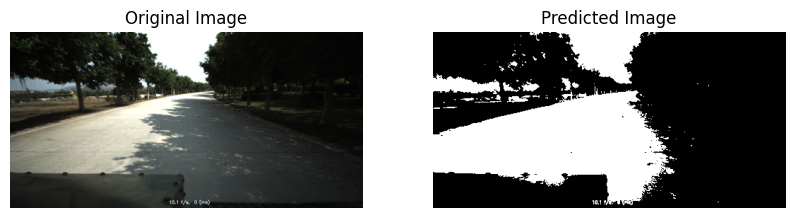

Predicted image saved to ./result_new/pred_0854_linear_4.jpg


In [18]:
# 显示原始图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 显示预测后的图片
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.title('Predicted Image')
plt.axis('off')

# 显示图像
plt.show()
    
# 保存预测后的图片
new_image_name = os.path.splitext(os.path.basename(new_image_path))[0]
save_path = f'./result_new/pred_{new_image_name}_linear_4.jpg'
cv2.imwrite(save_path, predicted_image)
print(f'Predicted image saved to {save_path}')